# Solution 2

## FINM 37500 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

#### Updated March 4

The stripping of the caps utilizes `flat_to_forward_vol`. Before the update, this function was calling an incorrect version of the function.

With the update, the forward volatilities are corrected, which impacts the pricing info below.

# 1. Stripping Caps

The file `data/cap_curves_2024-02-16.xlsx` has market data on the following curves:
* swap rates (SOFR)
* discount factors
* forward rates 
* flat volatilites

A few details
* the swap and forward rates are quarterly compounded.
* the flat volatilites are (Black) quotes on caps containing caplets ranging from expiration of $\tau=.5$ to $\tau=T$.
* the details of the data prep can be found in `build_data/Process Cap Quotes`.

## Context

Recall that 
* a cap is made of caplets with $.5\le \tau \le T$
* the flat volatility at $T$ is input for every caplet corresponding to the cap of $T$.
* use Black's formula for this calculation.
* in Black's formula, use $T-0.25$ as the rate for the caplet is determined one period before it is paid.

As for the cap parameters,
* the cap's strike is the swap rate with the same tenor. So the $T=2$ cap is struck at the swap rate of $\tau=2$.
* the notional of the cap is $100.
* the payoff of each caplet is

$$\frac{100}{n}\max(r-K,0)$$

where $n$ is the frequency; here $n=4$.

Thus, the corresponding value in Black's fomula for a caplet is
$$P^{\text{cap}}_{T} = \frac{100}{n} \sum_{\tau=.5}^T B_{\text{call}}(\overline{\sigma}_T, \tau-.25, K=s_T, f_{\tau}, Z_{\tau})$$
Note here that for every caplet in cap $T$, we plug in the same 
* flat vol with tenor $T$.
* strike which is the swap rate of maturity $T$.

The notation above is using subscripts for tenor / maturity rather than time period. That is, $Z_{\tau}$ denotes $Z(t, t+\tau)$ which is today's discount factor for maturity $\tau$. Similarly for the swap rate of tenor $T$, denoted above $s_T$ and forward rate $f(t,t+\tau-.25, t+\tau)$ denoted simply $f_{\tau}$.

### Black's Formula
Recall Black's formula:

$$\begin{align}
B_{\text{call}}(\sigma, T, K, f, Z) = &\; Z\left[f\mathcal{N}\left(d_1\right) - K\mathcal{N}(d_2)\right] \\
d_1 =& \frac{\ln\left(\frac{f}{K}\right) + \frac{\sigma^2}{2}T}{\sigma\sqrt{T}} \\
d_2 =& d_1 -\sigma\sqrt{T}
\end{align}
$$

## 1.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

## 1.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

## 1.3 Calibrate a BDT model 

Use data from the file `data/cap_curves_2024-02-16.xlsx` to calibrate the BDT model.
* Use the forward volatilities calculated in 1.2 to calibrate $\sigma$ at each step. 
* You do not have a forward volatility at $\tau=.25$ given there is no caplet there. For purposes of the BDT model, assume $\sigma_{.25}$ is equal to the forward volatility at the first estimated period, $t=0.50$. That is, use the first estimated forward vol (corresponding to $\tau=.50$ for both $t=.25$ and $t=.50$ in the BDT tree.    

Given these volatility parameters, calibrate the series of $\theta$ to fit the zero-coupon bond prices given by `discounts` (multiplied by 100).

**Display**
* the series of $\theta$ parameters.
* the tree of rates from $0\le t \le 10$.

***

# **<span style="color:red">Solution 1</span>**

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

In [2]:
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

## Stripping Caps

In [3]:
DATE = '2024-02-16'
curves = pd.read_excel(f'../data/cap_curves_{DATE}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')

In [4]:
curves

,swap rates,discounts,forwards,flat vols,fwd vols
tenor,,,,,
0.25,0.053220,0.986870,NaN,NaN,NaN
0.50,0.052569,0.974225,0.051917,0.164498,0.164498
0.75,0.051547,0.962315,0.049503,0.189530,0.208622
1.00,0.050334,0.951210,0.046700,0.214562,0.251768
1.25,0.048626,0.941373,0.041799,0.257098,0.355909
1.50,0.047222,0.932004,0.040209,0.288577,0.372774
1.75,0.046049,0.923001,0.039018,0.310668,0.379028
2.00,0.045095,0.914218,0.038426,0.325038,0.375009
2.25,0.044138,0.905954,0.036487,0.333356,0.362712


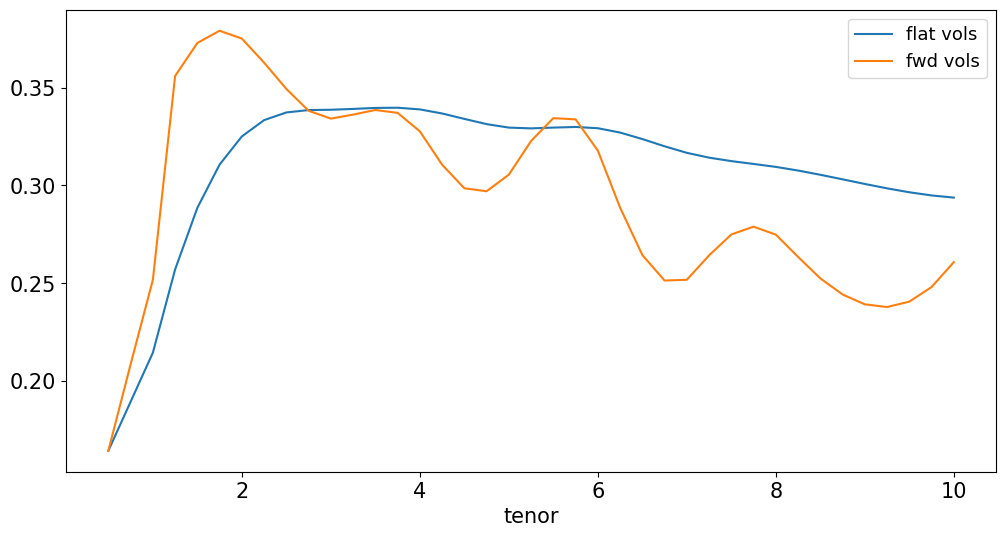

In [5]:
capcurves = flat_to_forward_vol(curves)

capcurves[['flat vols','fwd vols']].plot();

### Calibrating Theta

In [6]:
quotes = curves['discounts']*100

In [7]:
sigmas = capcurves['fwd vols']
sigmas.iloc[0] = sigmas.iloc[1]

theta, ratetree = estimate_theta(sigmas,quotes)
format_bintree(theta.to_frame().T, style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
theta,,-11.18%,-25.39%,-34.70%,-72.14%,-42.25%,-35.67%,-25.10%,-33.93%,-2.57%,-0.04%,5.25%,-16.27%,-6.03%,14.39%,5.58%,-7.22%,5.69%,21.70%,14.22%,0.21%,-3.55%,-1.95%,3.13%,10.69%,15.30%,17.01%,15.88%,12.37%,10.00%,9.18%,9.99%,12.21%,14.12%,15.41%,16.07%,16.02%,15.15%,13.37%,10.55%


### Rate Tree

In [8]:
format_bintree(ratetree,style='{:.2%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.29%,5.58%,5.81%,6.05%,6.03%,6.54%,7.23%,8.19%,9.02%,10.67%,12.64%,15.13%,17.19%,20.06%,24.61%,29.39%,33.72%,39.71%,48.63%,58.71%,69.03%,80.87%,95.09%,112.34%,133.30%,158.08%,187.04%,220.72%,259.82%,305.65%,359.55%,422.96%,497.48%,584.71%,686.63%,805.62%,944.46%,1106.35%,1295.05%,1514.88%
1,,4.74%,4.93%,5.13%,5.12%,5.55%,6.13%,6.95%,7.65%,9.05%,10.72%,12.84%,14.58%,17.01%,20.87%,24.94%,28.60%,33.68%,41.26%,49.81%,58.56%,68.60%,80.66%,95.30%,113.08%,134.10%,158.67%,187.24%,220.41%,259.29%,305.02%,358.80%,422.02%,496.02%,582.48%,683.43%,801.20%,938.54%,1098.61%,1285.10%
2,,,4.00%,4.16%,4.15%,4.50%,4.98%,5.64%,6.21%,7.35%,8.70%,10.42%,11.84%,13.81%,16.94%,20.24%,23.22%,27.34%,33.49%,40.43%,47.53%,55.68%,65.48%,77.36%,91.79%,108.85%,128.79%,151.99%,178.90%,210.47%,247.58%,291.24%,342.56%,402.62%,472.80%,554.74%,650.34%,761.81%,891.75%,1043.12%
3,,,,3.24%,3.23%,3.50%,3.87%,4.38%,4.83%,5.71%,6.77%,8.10%,9.20%,10.74%,13.17%,15.74%,18.05%,21.26%,26.03%,31.43%,36.95%,43.29%,50.90%,60.14%,71.36%,84.62%,100.13%,118.16%,139.08%,163.62%,192.48%,226.42%,266.31%,313.01%,367.57%,431.27%,505.59%,592.25%,693.27%,810.95%
4,,,,,2.26%,2.45%,2.71%,3.07%,3.38%,4.00%,4.74%,5.68%,6.45%,7.52%,9.23%,11.02%,12.64%,14.89%,18.24%,22.02%,25.89%,30.33%,35.66%,42.13%,49.99%,59.28%,70.14%,82.77%,97.43%,114.62%,134.84%,158.61%,186.56%,219.27%,257.50%,302.12%,354.18%,414.89%,485.66%,568.10%
5,,,,,,1.69%,1.87%,2.12%,2.33%,2.76%,3.26%,3.91%,4.44%,5.18%,6.36%,7.59%,8.71%,10.26%,12.56%,15.17%,17.83%,20.89%,24.56%,29.02%,34.43%,40.83%,48.32%,57.02%,67.11%,78.95%,92.88%,109.26%,128.51%,151.04%,177.37%,208.11%,243.97%,285.79%,334.53%,391.32%
6,,,,,,,1.28%,1.45%,1.60%,1.89%,2.23%,2.68%,3.04%,3.55%,4.35%,5.20%,5.96%,7.02%,8.60%,10.38%,12.21%,14.30%,16.81%,19.86%,23.57%,27.95%,33.07%,39.03%,45.94%,54.05%,63.58%,74.79%,87.97%,103.39%,121.41%,142.45%,167.00%,195.63%,229.00%,267.87%
7,,,,,,,,1.00%,1.10%,1.30%,1.54%,1.84%,2.09%,2.44%,2.99%,3.57%,4.10%,4.83%,5.91%,7.13%,8.39%,9.83%,11.56%,13.65%,16.20%,19.21%,22.73%,26.82%,31.57%,37.15%,43.70%,51.40%,60.46%,71.06%,83.45%,97.91%,114.78%,134.45%,157.38%,184.10%
8,,,,,,,,,0.76%,0.90%,1.07%,1.28%,1.45%,1.70%,2.08%,2.49%,2.85%,3.36%,4.11%,4.96%,5.84%,6.84%,8.04%,9.50%,11.27%,13.37%,15.82%,18.66%,21.97%,25.85%,30.40%,35.76%,42.07%,49.44%,58.06%,68.12%,79.86%,93.55%,109.51%,128.09%


***

# 2. Pricing a Callable Bond with BDT

## Freddie Mac

The U.S. has many forms of *agency* debt in addition to *Treasury* debt. The largest of these *agency* issuers are the housing entities commonly referred to as Freddie Mac and Fannie Mae. While technically distinct from the U.S. Treasury, they are widely seen as having the full credit and backing of the Treasury--particularly after the bailouts of 2008.

Thus, we will examine this agency debt as (credit) risk-free, just like Treasury debt.

Consider the Freddie Mac bond
* Bloomberg Ticker `FHLMC 6 02/21/34 Corp`
* Bloomberg ID `COZD1131782`
* CUSIP `3134H1TN3`

Bond description
* Issued 2024-02-16
* Matures 2034-02-21
* Semiannual coupons
* Coupon rate 6.00%

Note that these bonds are not a niche market. Just this particular bond was issued with \$15 billion face value.

## 2.1 Price the Freddie Mac Bond


Assume today is `2024-02-16`.
* The market price on this day is `$99.953`.
* Approximate the TTM (time-to-maturity) to be exactly 10 years.

Price this bond using the model calibrated from  data.
* Price it with the BDT model calibrated in the previous problem.
* Note that the coupons are paid semiannually whereas the tree steps are quarterly.

Report the tree of bond prices, emphasizing the current modeled price.

How does our modeled price compare to the market price?

## 2.2 Callable Bond

One important difference between Treasury debt and this bond is that this bond is **callable**
* Note that the holder of the bond is short this call option; (the issuer has the optionality.) 

#### Style
* (approximately) American style
* called only on quarterly dates, not any date
* since our tree is quarterly, this means callable on any date on our tree.

#### Strike
* Strike is 100.
* The strike is based on the **clean** price of the bond, meaning the price which does not account for accrued interest.
    * In pricing the bond in the previous problem, you should have considered the accrued coupons, or dirty prices.
    * But in analyzing the option, you must consider its moneyness and payoff based on the clean price.

### Pricing
Use the BDT model to price this implicit American call option and the resulting callable bond.
* Note that the price of the callable bond is your answer to the previous question minus this American option.
* How close is the modeled price to the market quoted price now that you are accounting for the short embedded option? 

Does the price of the callable bond ever get above \$100?

## 2.3 Exercising the Option

Show a heatmap of the nodes in which the American bond is exercised.

Is it exercised every time it is in-the-money?

***

# **<span style="color:red">Solution 2</span>**

The approach is to decompose the Freddie Mac callable bond into...

$$\text{callable bond} = \text{vanilla bond} - \text{call option on vanilla bond}$$

### Parameters of the Bond

In [9]:
FACE = 100
T=10
compound = 4
cpn = .06
cpn_freq = 2

STRIKE = 100
CLEANCALL = True

MKTPRICE = 99.953

dt = 1/compound
tsteps = int(T/dt)

In [10]:
wrapper_bond = lambda r: payoff_bond(r, dt, facevalue=FACE * (1+cpn/cpn_freq))
payoff_call = lambda p: np.maximum(p-STRIKE,0)

### Cashflow tree

The cashflows are simply the coupons.
* We include the final coupon as part of the final payoff function rather than in the cashflow function.

In [11]:
cftree = construct_bond_cftree(T, compound, cpn)

## Price the vanilla bond

Timing is that on coupon nodes, the value shown in the tree is **ex-coupon**.

Calculating the dirty prices (total value) is more direct.

But we must translate to the clean prices to compare with the (clean) strike.

### Bond price tree (dirty)

Note that the vanilla bond is priced well above par.
* coupon is 6%
* swap rate (ytm) at that maturity is less than 4%

The highlighting below shows when it is above or below par value.

In [12]:
def highlight_values(val,thresh=100):
    if pd.isna(val):
        color = '#d3d3d3'  # Light grey for NaN values
    elif val < thresh:
        color = '#ffcccc'  # Light red
    else:
        color = '#ccffcc'  # Light green
    return f'background-color: {color}'

In [13]:
bondtree = bintree_pricing(payoff=wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps], cftree=cftree)
bondtree.style.format('{:.2f}',na_rep='').applymap(highlight_values).format_index('{:.2f}',axis=1)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,116.65,113.10,106.26,102.08,94.58,89.68,81.57,76.27,67.93,62.51,54.26,49.19,41.50,37.06,30.10,26.63,20.82,18.37,13.60,12.24,8.59,8.11,5.26,5.37,3.14,3.62,1.83,2.49,1.03,1.72,0.54,1.16,0.24,0.73,0.09,0.41,0.03,0.20,0.13,2.33
1,,123.30,117.11,113.56,106.68,102.36,94.75,89.85,81.77,76.45,68.13,62.81,54.67,49.59,41.82,37.40,30.51,26.93,20.97,18.48,13.75,12.31,8.58,7.98,5.10,5.13,2.93,3.36,1.63,2.23,0.86,1.49,0.42,0.96,0.18,0.58,0.08,0.36,0.38,4.15
2,,,126.43,123.56,117.37,113.76,106.83,102.58,95.07,90.24,82.27,77.16,69.05,63.82,55.68,50.72,43.09,38.62,31.61,28.02,22.12,19.53,14.65,13.02,9.15,8.39,5.43,5.34,3.09,3.42,1.69,2.21,0.88,1.43,0.44,0.93,0.29,0.78,1.14,7.59
3,,,,131.84,126.33,123.44,117.26,113.76,107.00,102.88,95.56,91.01,83.34,78.43,70.44,65.45,57.61,52.72,45.09,40.72,33.88,30.28,24.25,21.49,16.44,14.62,10.60,9.65,6.54,6.26,3.88,4.05,2.27,2.69,1.39,1.95,1.19,2.14,3.40,13.56
4,,,,,133.50,131.27,125.79,123.03,117.03,113.71,107.16,103.37,96.40,92.13,84.69,80.14,72.56,67.81,60.11,55.52,48.22,44.04,37.23,33.60,27.51,24.68,19.53,17.58,13.39,12.26,8.95,8.52,6.01,6.13,4.37,5.02,4.27,6.25,9.45,24.89
5,,,,,,137.25,132.36,130.25,124.93,122.34,116.54,113.51,107.29,103.79,97.08,93.20,86.20,81.96,74.65,70.31,63.09,58.85,51.79,47.80,41.15,37.67,31.71,28.97,23.85,21.90,17.69,16.57,13.31,13.04,10.84,11.62,11.12,14.44,19.81,38.72
6,,,,,,,137.31,135.72,130.95,128.98,123.83,121.48,115.96,113.19,107.22,104.07,97.77,94.22,87.54,83.75,76.97,73.08,66.23,62.35,55.64,52.01,45.73,42.61,36.96,34.51,29.68,28.06,24.24,23.67,21.19,22.16,22.00,26.48,33.21,52.72
7,,,,,,,,139.78,135.46,133.98,129.35,127.56,122.63,120.50,115.18,112.71,107.09,104.25,98.25,95.12,88.94,85.62,79.25,75.80,69.40,66.02,59.83,56.74,50.99,48.41,43.33,41.51,37.42,36.73,34.12,35.25,35.28,40.31,47.16,65.01
8,,,,,,,,,138.79,137.69,133.47,132.13,127.67,126.05,121.29,119.39,114.35,112.14,106.78,104.29,98.73,96.03,90.25,87.36,81.46,78.53,72.70,69.92,64.36,61.94,56.91,55.14,51.00,50.32,47.63,48.81,48.77,53.70,59.68,74.78


#### Clean Prices

We want to compare the (clean) strike to the **clean** bond price. Thus, we need to subtract accrued interest and coupons from the bond value tree.

$$P_{\text{clean}} = P_{\text{dirty}} - C_{\text{accrued int or coupon}}$$

Then, we will use this clean bond price tree as the underlying.

In [14]:
accint = construct_accint(bondtree.columns.values, compound, cpn)
cleantree = np.maximum(bondtree.subtract(accint,axis=1),0)

cleantree.style.format('{:.2f}',na_rep='').applymap(highlight_values).format_index('{:.2f}',axis=1)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,116.65,111.60,106.26,100.58,94.58,88.18,81.57,74.77,67.93,61.01,54.26,47.69,41.50,35.56,30.10,25.13,20.82,16.87,13.60,10.74,8.59,6.61,5.26,3.87,3.14,2.12,1.83,0.99,1.03,0.22,0.54,0.00,0.24,0.00,0.09,0.00,0.03,0.00,0.13,0.83
1,,121.80,117.11,112.06,106.68,100.86,94.75,88.35,81.77,74.95,68.13,61.31,54.67,48.09,41.82,35.90,30.51,25.43,20.97,16.98,13.75,10.81,8.58,6.48,5.10,3.63,2.93,1.86,1.63,0.73,0.86,0.00,0.42,0.00,0.18,0.00,0.08,0.00,0.38,2.65
2,,,126.43,122.06,117.37,112.26,106.83,101.08,95.07,88.74,82.27,75.66,69.05,62.32,55.68,49.22,43.09,37.12,31.61,26.52,22.12,18.03,14.65,11.52,9.15,6.89,5.43,3.84,3.09,1.92,1.69,0.71,0.88,0.00,0.44,0.00,0.29,0.00,1.14,6.09
3,,,,130.34,126.33,121.94,117.26,112.26,107.00,101.38,95.56,89.51,83.34,76.93,70.44,63.95,57.61,51.22,45.09,39.22,33.88,28.78,24.25,19.99,16.44,13.12,10.60,8.15,6.54,4.76,3.88,2.55,2.27,1.19,1.39,0.45,1.19,0.64,3.40,12.06
4,,,,,133.50,129.77,125.79,121.53,117.03,112.21,107.16,101.87,96.40,90.63,84.69,78.64,72.56,66.31,60.11,54.02,48.22,42.54,37.23,32.10,27.51,23.18,19.53,16.08,13.39,10.76,8.95,7.02,6.01,4.63,4.37,3.52,4.27,4.75,9.45,23.39
5,,,,,,135.75,132.36,128.75,124.93,120.84,116.54,112.01,107.29,102.29,97.08,91.70,86.20,80.46,74.65,68.81,63.09,57.35,51.79,46.30,41.15,36.17,31.71,27.47,23.85,20.40,17.69,15.07,13.31,11.54,10.84,10.12,11.12,12.94,19.81,37.22
6,,,,,,,137.31,134.22,130.95,127.48,123.83,119.98,115.96,111.69,107.22,102.57,97.77,92.72,87.54,82.25,76.97,71.58,66.23,60.85,55.64,50.51,45.73,41.11,36.96,33.01,29.68,26.56,24.24,22.17,21.19,20.66,22.00,24.98,33.21,51.22
7,,,,,,,,138.28,135.46,132.48,129.35,126.06,122.63,119.00,115.18,111.21,107.09,102.75,98.25,93.62,88.94,84.12,79.25,74.30,69.40,64.52,59.83,55.24,50.99,46.91,43.33,40.01,37.42,35.23,34.12,33.75,35.28,38.81,47.16,63.51
8,,,,,,,,,138.79,136.19,133.47,130.63,127.67,124.55,121.29,117.89,114.35,110.64,106.78,102.79,98.73,94.53,90.25,85.86,81.46,77.03,72.70,68.42,64.36,60.44,56.91,53.64,51.00,48.82,47.63,47.31,48.77,52.20,59.68,73.28


### Compare to straightforward bond pricing

The Freddie Mac bond (ignoring its callable nature) has no credit risk and fixed semiannual coupons. So we can price it directly as we would in FINM 37400.

(The reason we're pricing the vanilla bond on the tree is to set up the pricing of the call option.)

#### Technical note
These would be closer to matching in a different dataset. `2024-02-16` data has some compounding issues.

In [15]:
ytm_semi = compound_rate(curves.loc[T,'swap rates'],4,2)
pd.DataFrame([price_bond(ytm_semi, T, cpn),cleantree.iloc[0,0]],index=['bond formula','tree'],columns=['clean price']).style.format('${:.2f}')

,clean price
bond formula,$116.92
tree,$116.65


### Value the American Call options

Assuming that the strike on the embedded option is referring to the **clean** price.

Otherwise, try setting the parameter `CLEANCALL` to `False`.

In [16]:
if CLEANCALL:
    undertree = cleantree
else:
    undertree = bondtree
    
calltree = bintree_pricing(payoff=payoff_call, ratetree=ratetree.iloc[:tsteps,:tsteps], undertree= undertree, style='american')
format_bintree(calltree)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,17.71,14.06,10.78,8.02,5.78,4.02,2.70,1.75,1.09,0.64,0.36,0.19,0.10,0.04,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,,21.82,17.74,13.86,10.50,7.71,5.47,3.75,2.48,1.58,0.96,0.56,0.31,0.16,0.08,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,,,26.43,22.06,17.57,13.56,10.18,7.35,5.15,3.48,2.27,1.42,0.84,0.48,0.25,0.13,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,,,,30.34,26.33,21.94,17.26,13.25,9.77,6.97,4.82,3.22,2.06,1.26,0.73,0.40,0.21,0.10,0.04,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,,,,,33.50,29.77,25.79,21.53,17.03,12.80,9.33,6.59,4.51,2.96,1.86,1.11,0.63,0.34,0.16,0.07,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,,,,,,35.75,32.36,28.75,24.93,20.84,16.54,12.29,8.85,6.21,4.17,2.69,1.66,0.97,0.53,0.27,0.13,0.05,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,,,,,,,37.31,34.22,30.95,27.48,23.83,19.98,15.96,11.69,8.41,5.79,3.82,2.42,1.45,0.83,0.44,0.21,0.09,0.03,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,,,,,,,,38.28,35.46,32.48,29.35,26.06,22.63,19.00,15.18,11.21,7.91,5.34,3.47,2.15,1.26,0.69,0.35,0.16,0.06,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,,,,,,,,,38.79,36.19,33.47,30.63,27.67,24.55,21.29,17.89,14.35,10.64,7.35,4.89,3.11,1.88,1.07,0.56,0.26,0.11,0.04,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Heatmap of the call tree

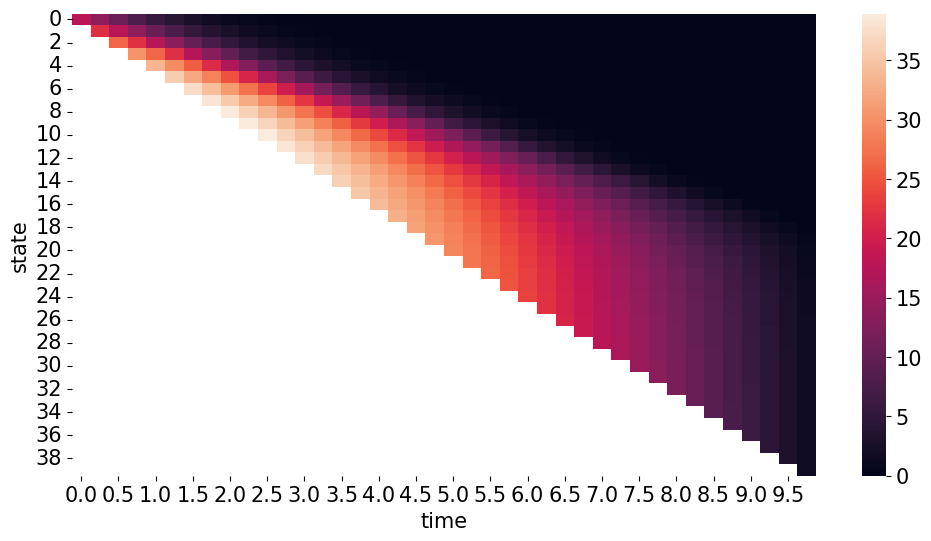

In [17]:
sns.heatmap(calltree);

### Price vs Market Price

In [18]:
QUOTE_CALLABLE_CLEAN = MKTPRICE
num_accrued = int((T*compound) %cpn_freq)
quote_callable_dirty = QUOTE_CALLABLE_CLEAN + num_accrued * (cpn/compound)*FACE

callablebondtree = bondtree - calltree
model_price_dirty = callablebondtree.iloc[0,0]
model_price_clean = model_price_dirty - accint.iloc[0]

prices = pd.DataFrame({'clean':[QUOTE_CALLABLE_CLEAN, model_price_clean], 'dirty':[quote_callable_dirty, model_price_dirty]}, index=['market quote','model'])
prices.style.format('{:.2f}')

,clean,dirty
market quote,99.95,99.95
model,98.94,98.94


### Callable Bond Tree (dirty)

Note that the bond's price never goes above par plus accrued interest.
* On coupon dates, the dirty price is displaying inclusive of the coupon.

Why is the price suddenly so much less?
* The embedded short call option ensures that if the bond's value were high, Freddie Mac would call it back!

In [19]:
callablebondtree.style.format('{:.2f}',na_rep='').applymap(highlight_values).format_index('{:.2f}',axis=1)

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,98.94,99.04,95.49,94.06,88.81,85.67,78.87,74.52,66.85,61.86,53.90,49.00,41.40,37.01,30.09,26.63,20.81,18.37,13.60,12.24,8.59,8.11,5.26,5.37,3.14,3.62,1.83,2.49,1.03,1.72,0.54,1.16,0.24,0.73,0.09,0.41,0.03,0.20,0.13,2.33
1,,101.48,99.37,99.71,96.18,94.65,89.28,86.10,79.29,74.88,67.18,62.26,54.37,49.43,41.74,37.36,30.50,26.92,20.97,18.48,13.75,12.31,8.58,7.98,5.10,5.13,2.93,3.36,1.63,2.23,0.86,1.49,0.42,0.96,0.18,0.58,0.08,0.36,0.38,4.15
2,,,100.00,101.50,99.80,100.19,96.65,95.22,89.93,86.76,80.01,75.74,68.21,63.34,55.42,50.59,43.04,38.59,31.60,28.02,22.11,19.53,14.65,13.02,9.15,8.39,5.43,5.34,3.09,3.42,1.69,2.21,0.88,1.43,0.44,0.93,0.29,0.78,1.14,7.59
3,,,,101.50,100.00,101.50,100.00,100.51,97.23,95.91,90.74,87.79,81.28,77.17,69.70,65.05,57.40,52.62,45.05,40.71,33.87,30.28,24.25,21.49,16.44,14.62,10.60,9.65,6.54,6.26,3.88,4.05,2.27,2.69,1.39,1.95,1.19,2.14,3.40,13.56
4,,,,,100.00,101.50,100.00,101.50,100.00,100.90,97.84,96.78,91.89,89.18,82.83,79.02,71.92,67.47,59.95,55.44,48.19,44.03,37.22,33.60,27.51,24.68,19.53,17.58,13.39,12.26,8.95,8.52,6.01,6.13,4.37,5.02,4.27,6.25,9.45,24.89
5,,,,,,101.50,100.00,101.50,100.00,101.50,100.00,101.23,98.44,97.58,92.90,90.51,84.54,81.00,74.12,70.04,62.97,58.80,51.77,47.79,41.14,37.67,31.71,28.97,23.85,21.90,17.69,16.57,13.31,13.04,10.84,11.62,11.12,14.44,19.81,38.72
6,,,,,,,100.00,101.50,100.00,101.50,100.00,101.50,100.00,101.50,98.81,98.28,93.94,91.81,86.08,82.92,76.53,72.87,66.14,62.31,55.63,52.01,45.73,42.61,36.96,34.51,29.68,28.06,24.24,23.67,21.19,22.16,22.00,26.48,33.21,52.72
7,,,,,,,,101.50,100.00,101.50,100.00,101.50,100.00,101.50,100.00,101.50,99.18,98.90,94.78,92.98,87.68,84.93,78.91,75.64,69.34,65.99,59.82,56.74,50.99,48.41,43.33,41.51,37.42,36.73,34.12,35.25,35.28,40.31,47.16,65.01
8,,,,,,,,,100.00,101.50,100.00,101.50,100.00,101.50,100.00,101.50,100.00,101.50,99.43,99.41,95.62,94.15,89.18,86.80,81.20,78.42,72.66,69.90,64.36,61.94,56.91,55.14,51.00,50.32,47.63,48.81,48.77,53.70,59.68,74.78


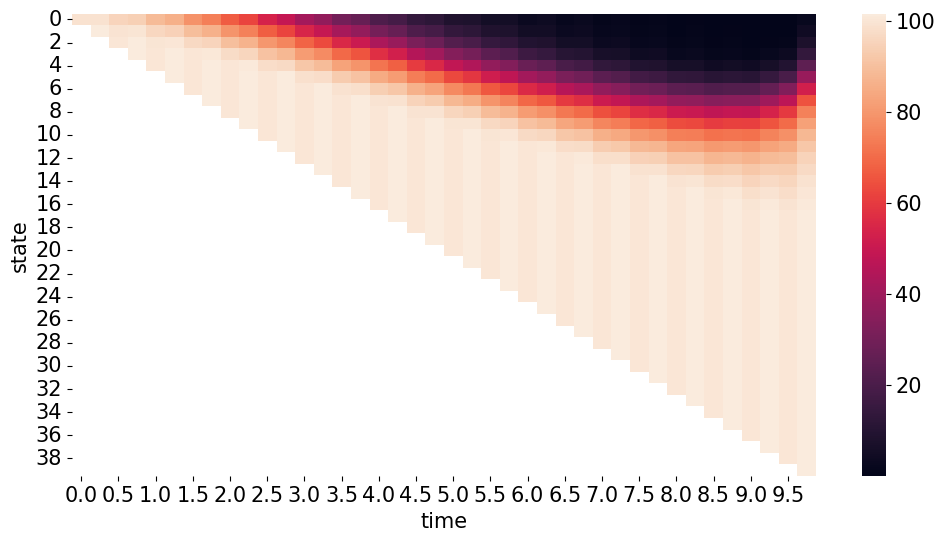

In [20]:
sns.heatmap(callablebondtree);

#### Compare 
to the heatmap of the value of the vanilla (non-callable) bond.

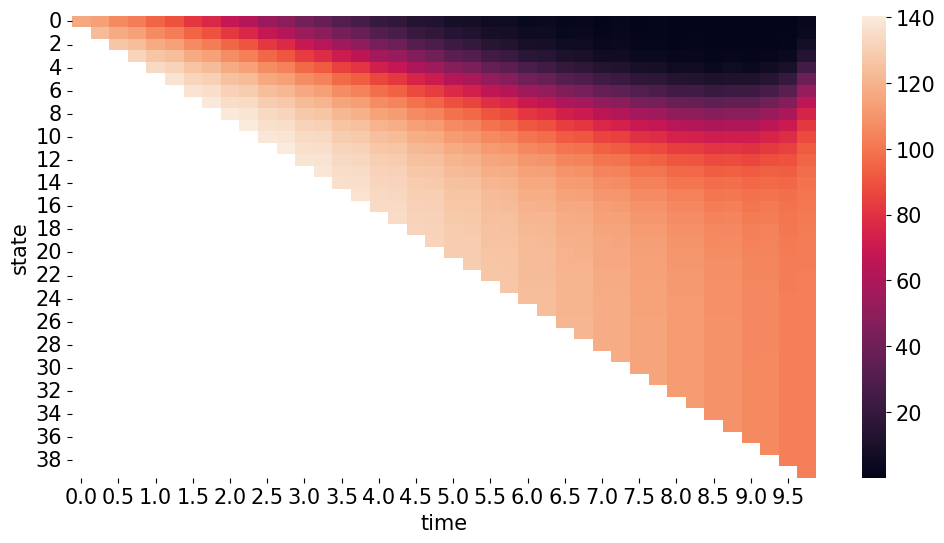

In [21]:
sns.heatmap(bondtree);

### Optimal Exercise

In [22]:
temp_ITM = undertree > STRIKE
temp_exer = exercise_decisions(payoff_call,undertree,calltree)
temp = (1*temp_ITM+temp_exer*2).where(calltree.notna(), np.nan)

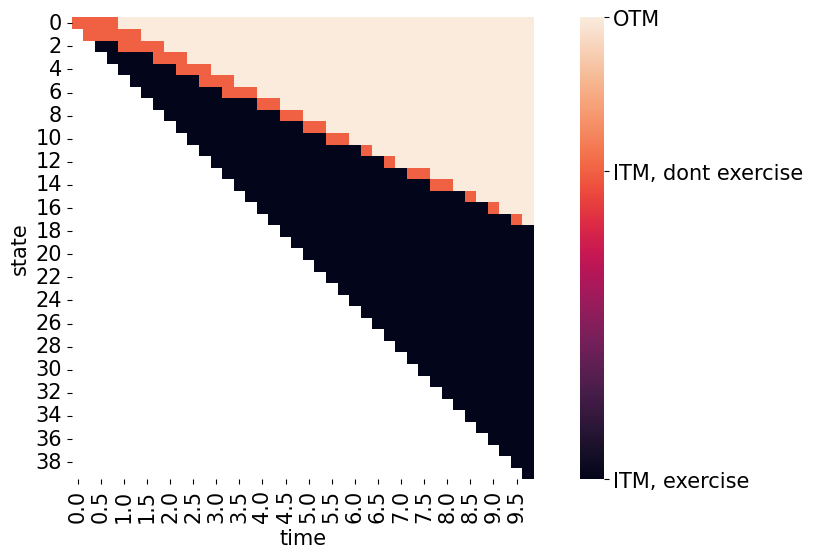

In [23]:
ax = sns.heatmap(-temp,square=True);

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-3, -1, 0])  # Set the positions of the ticks
colorbar.set_ticklabels(['ITM, exercise', 'ITM, dont exercise', 'OTM'])  # Set the tick labels

plt.show()

### Technical Point: Overpriced?

Our modeled price of the callable bond is lower than the market's quoted price.

Our model could be poorly...
* **calibrated** (to the caps, swaps, etc.)
* **implemented** (time grid, interpolated rate curves, etc.)

The market could be mispricing these bonds!
* Callable bonds are seemingly overpriced in many situations.
* Perhaps the issuer does not exercise (call) at optimal times.
* Why might this overpricing be hard to arbitrage?
* Francis Longstaff (1992) has a good discussion of mispriced callable Treasury bonds.

***

# 3. Option Adjusted Spread

*This section is optional. No need to submit it, but we will likely discuss it in class.*

## 3.1 Calculate the OAS

The **option adjusted spread** is the spread one would need to add to the spot curve, (the discounts), to get the modeled price to match the market price of the derivative. That is, how many bps would you need to add or subtract to all the spot rates in order to perfectly price this callable bond? 

* Ignore the effect of the parallel shift in rates on the forward vols. (No need to recalculate section 1.) 

* Use the parallel shifts to recalibrate the $\theta$ parameters in the BDT tree. 

Report the OAS needed to add (or subtract) in a parallel shift in spot to correctly model the callable bond.

#### Note:
This **OAS** is a common way to quote whether a derivative seems to be undervalued (positive OAS) or overvalued (negative OAS.) Of course, the OAS is dependent on our modeling choices, so it could also indicate the model is bad.

## 3.2 Convexity

Continue with parallel shifts of the (present, market quoted) yield curve. 
* Plot the relationship between the value of the callable bond as the spot curve shifts higher and lower.
* Do you see convexity in this relationship?

***

# **<span style="color:red">Solution 3</span>**

### Warning: solutions take several minutes to run

In [24]:
def wrapper_callable_price(dr):
    quotes = ratecurve_to_discountcurve(curves['swap rates'].loc[:T] + dr, n_compound=compound)*FACE
    error = quote_callable_dirty - price_callable(quotes.loc[:T], sigmas.loc[:T], cftree, accint,  wrapper_bond, payoff_call, cleanstrike=CLEANCALL)
    return error

In [25]:
from IPython.display import display, HTML

In [26]:
oas = fsolve(wrapper_callable_price, 0)[0]

In [27]:
pd.DataFrame([oas],columns=['option adjusted spread'],index=['freddie mac bond']).style.format('{:.2%}')

,option adjusted spread
freddie mac bond,-0.55%


In [28]:
display(HTML(f"<strong><span> The OAS for pricing the callable bond is</span></strong> <strong><span style='color: red'>{oas:.2%}</span></strong>"))

Verify that OAS brings modeled price to match market price

Shift the swap curve by the OAS spread and check that model price is same as the market quote.

In [29]:
quotes = ratecurve_to_discountcurve(curves['swap rates'].loc[:T] + oas, n_compound=compound)*FACE
prices.loc['model w/ oas','dirty'] = price_callable(quotes.loc[:T], sigmas.loc[:T], cftree, accint,  wrapper_bond, payoff_call, cleanstrike=CLEANCALL)
prices.style.format('{:.2f}')

,clean,dirty
market quote,99.95,99.95
model,98.94,98.94
model w/ oas,nan,99.95


## **<span style="color:red">3.2</span>**

#### Get reaction curve

In [30]:
dr_inc = .0025
drvec = np.arange(-.0250,.0275,dr_inc)

In [31]:
tsteps = int(T/dt)

cftree = construct_bond_cftree(T,compound,cpn)
accint = construct_accint(cftree.columns.values, compound, cpn)

Loop through possible rate shifts, repricing callable bond via BDT.

In [32]:
ytm = curves.loc[T,'swap rates']

modpx = pd.Series(dtype=float, index=drvec+ytm, name='callable')
for numdr, dr in enumerate(drvec):
    quotes = ratecurve_to_discountcurve(curves['swap rates'].loc[:T] + dr, n_compound=compound)*FACE
    modpx.loc[dr+ytm] = price_callable(quotes.loc[:T], sigmas.loc[:T], cftree, accint,  wrapper_bond, payoff_call,cleanstrike=CLEANCALL)

#### Compare to non-callable bond

In [33]:
pxvanilla = pd.Series(dtype=float, index=(drvec+ytm),name='non-callable')
for dr in drvec:
    pxvanilla.loc[dr+ytm] = price_bond(ytm_semi+dr, T, cpn, accr_frac=.5)

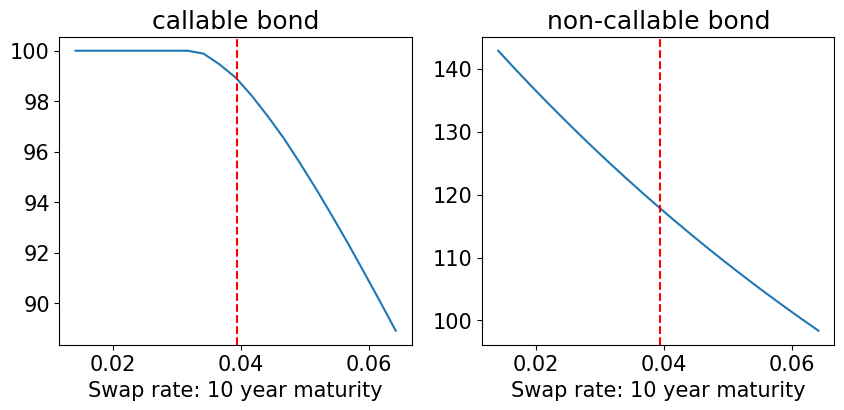

In [34]:
tab_comp = pd.concat([pxvanilla,modpx],axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

tab_comp['callable'].plot(ax=axes[0], title='callable bond',xlabel=f'Swap rate: {T} year maturity');
axes[0].axvline(x=ytm_semi, color='red', linestyle='--')

tab_comp['non-callable'].plot(ax=axes[1], title='non-callable bond',xlabel=f'Swap rate: {T} year maturity');
axes[1].axvline(x=ytm_semi, color='red', linestyle='--')

plt.show()

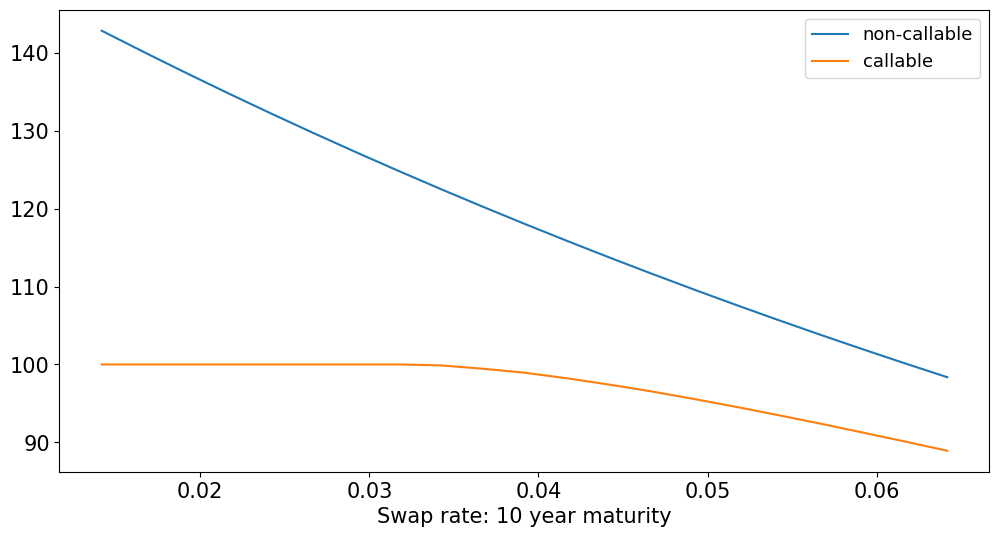

In [35]:
tab_comp.plot(xlabel=f'Swap rate: {T} year maturity')
plt.show()

Note a few things
* there is negative convexity in the callable bond
* callable bond's price is lower at all rate levels
* callable bond's value does not go above par for any rate level

### Technical Note: Alternate Ways to Compute OAS

Overall, OAS is based on
* changing the discounting
* not changing the cashflows

For this bond, the cashflows are not dependent on the interest rate anyway. But in case of other derivatives where cashflows depend on the rate, (swaptions, etc.) the shift of the discounts should only be applied to the pricing via the discounting, not the cashflows.